Epoch 0, Loss: 0.0018180336337536573
Epoch 200, Loss: 2.690729843379813e-07
Epoch 400, Loss: 2.0365821740142565e-07
Epoch 600, Loss: 1.570961956076644e-07
Epoch 800, Loss: 1.1330407545528942e-07
Epoch 1000, Loss: 9.799954625577811e-08
Epoch 1200, Loss: 8.832212472498213e-08
Epoch 1400, Loss: 8.278598784272617e-08
Epoch 1600, Loss: 7.84241365181515e-08
Epoch 1800, Loss: 7.488738162919617e-08


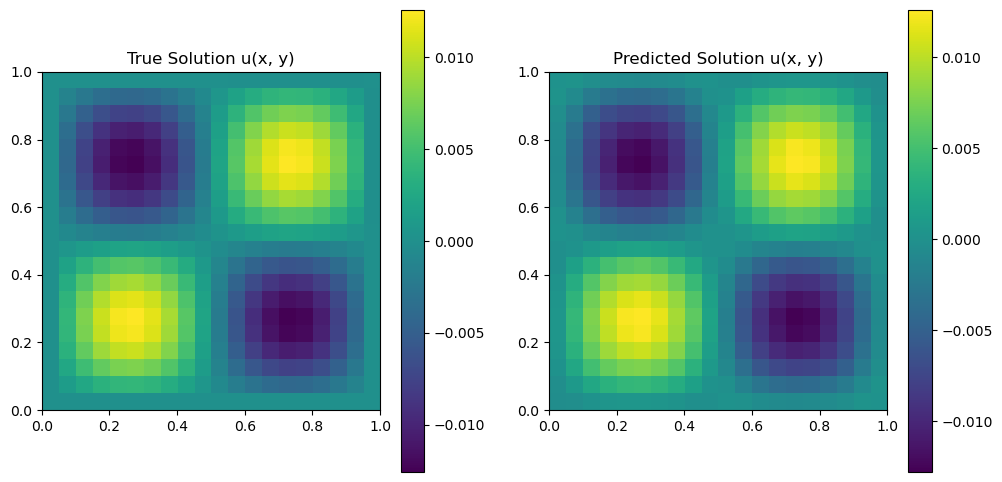

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

# Define the Graph Neural Operator model for 2D Poisson equation
class GraphNeuralOperator2D(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphNeuralOperator2D, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

def generate_synthetic_data_2d(grid_size):
    """
    Generate synthetic data for training the Graph Neural Operator in 2D.
    The source term f(x, y) and the true solution u(x, y) are generated using a simple 2D finite difference approach.
    """
    # Define 2D grid points
    x = torch.linspace(0, 1, grid_size)
    y = torch.linspace(0, 1, grid_size)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    
    # Flatten the grid for graph representation
    xx_flat = xx.flatten().view(-1, 1)
    yy_flat = yy.flatten().view(-1, 1)
    grid_points = torch.cat([xx_flat, yy_flat], dim=1)
    
    # Define the source term f(x, y)
    f_xy = torch.sin(2 * torch.pi * xx) * torch.sin(2 * torch.pi * yy)  # Example source term
    f_xy_flat = f_xy.flatten().view(-1, 1)
    
    # Define the true solution u(x, y) using a simple finite difference approach
    u_xy = (1 / (8 * torch.pi**2)) * torch.sin(2 * torch.pi * xx) * torch.sin(2 * torch.pi * yy)  # Analytical solution
    u_xy_flat = u_xy.flatten().view(-1, 1)
    
    return grid_points, f_xy_flat, u_xy_flat

def create_2d_graph(grid_size):
    """
    Create a graph representation of a 2D grid where each node is connected to its 4 nearest neighbors.
    """
    # Initialize edge list
    edges = []
    for i in range(grid_size):
        for j in range(grid_size):
            node_index = i * grid_size + j
            # Add edges for 4-nearest neighbors (if within bounds)
            if i > 0:  # Up
                edges.append([node_index, node_index - grid_size])
            if i < grid_size - 1:  # Down
                edges.append([node_index, node_index + grid_size])
            if j > 0:  # Left
                edges.append([node_index, node_index - 1])
            if j < grid_size - 1:  # Right
                edges.append([node_index, node_index + 1])
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return edge_index

# Generate synthetic data for 2D Poisson equation
grid_size = 20  # Grid size for 20x20 nodes
grid_points, source_term, true_solution = generate_synthetic_data_2d(grid_size)
edge_index = create_2d_graph(grid_size)  # Create graph for 2D grid

# Initialize the GNO model
model = GraphNeuralOperator2D(in_channels=1, hidden_channels=64, out_channels=1)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Training loop
num_epochs = 2000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass: input is the source term f(x, y)
    pred_solution = model(source_term, edge_index)
    
    # Compute loss between predicted and true solution
    loss = loss_fn(pred_solution, true_solution)
    loss.backward()
    optimizer.step()
    
    # Print loss every 200 epochs
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Evaluate model performance
model.eval()
with torch.no_grad():
    pred_solution = model(source_term, edge_index)

# Reshape for plotting
true_solution_2d = true_solution.view(grid_size, grid_size).numpy()
pred_solution_2d = pred_solution.view(grid_size, grid_size).numpy()

# Plot true vs predicted solution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(true_solution_2d, extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
plt.colorbar()
plt.title('True Solution u(x, y)')

plt.subplot(1, 2, 2)
plt.imshow(pred_solution_2d, extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
plt.colorbar()
plt.title('Predicted Solution u(x, y)')

plt.show()